# TP1 de IFT-3700
Mehdi Aqdim

Maxime Daigle

Adam Félix

Jonathan Graveline

## Preprocessing

Charger les données

et reduire les pixels a noir ou blanc (0 ou 1)

In [2]:
import numpy as np

from sklearn.preprocessing import Binarizer

"""
    Mettre `skiprows=1` pour avoir toutes les données.
    (Mais c'est très long surtout pour faire des tests.)
"""
mnist_train = np.loadtxt('mnist_train.csv', dtype='int', delimiter=',', skiprows=59001)
mnist_test  = np.loadtxt('mnist_test.csv', dtype='int', delimiter=',', skiprows=9501)

#print(mnist_train[0])

train_label = mnist_train[:,0]
train_data  = mnist_train[:,1:]

test_label  = mnist_test[:,0]
test_data   = mnist_test[:,1:]

#print(train_data.shape[1])

"""
    Décommentez les 5 lignes suivantes pour
        avoir des valeurs binaires
        (10 c'est le treshold... 128 serait peut-être mieux)
"""

#pp = Binarizer(10)

#pp.fit(train_data)
#train_data_d1 = pp.transform(train_data)

#pp.fit(test_data)
#test_data_d1  = pp.transform(test_data)

#print(train_data.shape[1])
#print(train_data[0])

"\n    Décommentez les 5 lignes suivantes pour\n        avoir des valeurs binaires\n        (10 c'est le treshold... 128 serait peut-être mieux)\n"

## Mesures

In [3]:
# distance euclidien
from sklearn.metrics import euclidean_distances

# Similarité cosine
# http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
from sklearn.metrics.pairwise import cosine_similarity

# Chi2 kernel
# http://scikit-learn.org/stable/modules/metrics.html#chi-squared-kernel
from sklearn.metrics.pairwise import chi2_kernel

# Sigmoid kernel
# http://scikit-learn.org/stable/modules/metrics.html#sigmoid-kernel
from sklearn.metrics.pairwise import sigmoid_kernel

# RBF kernel
# http://scikit-learn.org/stable/modules/metrics.html#rbf-kernel
from sklearn.metrics.pairwise import rbf_kernel

# Laplacian kernel
# http://scikit-learn.org/stable/modules/metrics.html#laplacian-kernel
from sklearn.metrics.pairwise import laplacian_kernel

# Polynomial kernel
# http://scikit-learn.org/stable/modules/metrics.html#polynomial-kernel
from sklearn.metrics.pairwise import polynomial_kernel



## Distance, essai 1: density

C'est une facon de considerer les points voisins dans le calcul. Ce qui je crois devrais aider...

Calcul de la densite a chaque point:

In [2]:
def in_bounds(pi, x, y):
    ret = pi + x + (y * 28)
    if ret > 783:
        return 783
    elif ret < 0:
        return 0
    else:
        return ret

def get_density(data, radius):
    rdata = []
    rrange = range(-radius,radius+1)
    for ei in range(data.shape[0]):
        ex = data[ei]
        nex = []
        for pi in range(ex.shape[0]):
            nex.append(sum([ex[in_bounds(pi,x,y)] for x in rrange for y in rrange]))
        rdata.append(nex)
    return np.array(rdata)

train_data_d1 = get_density(train_data, 1)
test_data_d1  = get_density(test_data, 1)

#print(pp_data.shape[1])
#print(pp_data[0])

In [3]:

"""
    Note 1: This is useless, data set is already transformed,
        so we may use euclidean distance directly on density map.
    
    Note 2: Built-in euclidean is way faster! Better hack data set
        and use built-in euclidean.
"""
def distance_1(lhs, rhs):
    #assert(lhs.shape == rhs.shape)
    ret = 0
    for pi in range(lhs.shape[0]):
        ret += abs(lhs[pi] - rhs[pi])
    return ret

print('Distance of train_data[0] to itself == %d' % distance_1(train_data[0],train_data[0]))

Distance of train_data[0] to itself == 0


## KNN

Algorithme de classification

In [4]:
from sklearn.neighbors import NearestNeighbors

def knn(n, r, d):
    return NearestNeighbors(n, r, metric=d, n_jobs=6)

## Evaluation of performance:

In [5]:
def get_best(idxs, train_label):
    counts = np.bincount(train_label[idxs])
    return np.argmax(counts)

def perf_knn(train_set, train_label, test_set, test_label):
    n_tests = test_label.shape[0]
    
    algo = knn(11, 1.0, 'euclidean')
    algo.fit(train_set)
    
    idxs = algo.kneighbors(test_set, return_distance=False)
    
    ret = sum([(get_best(idxs[idx], train_label) == test_label[idx]) for idx in range(n_tests)])
    
    return ((ret * 100.0) / test_set.shape[0])

In [6]:
""" Avec les données modifiées. """
result = perf_knn(train_data_d1, train_label, test_data_d1, test_label)

print('perf_knn (distance_1) == %.4f %%' % result)

""" Avec les données originales. """
result = perf_knn(train_data, train_label, test_data, test_label)

print('perf_knn (euclidean)  == %.4f %%' % result)

perf_knn (distance_1) == 90.0000 %
perf_knn (euclidean)  == 89.4000 %


## Isomap

Algorithme de reduction de dimensionnalite

In [7]:
from sklearn.manifold import Isomap

"""
    À revoir pour ajouter notre distance.
"""

isomap_2d = Isomap(n_components=2, n_jobs=-1)

(25, 25)


## PCoA

Algorithme de reduction de dimensionnalite

In [4]:
import time
seed = np.random.RandomState(seed=3)

from sklearn.manifold import MDS

#PCoA reducing to 2 dimensions
mds = MDS(n_components=2, random_state=seed, dissimilarity="precomputed", n_jobs=-1)

distance euclidien 

In [6]:
start = time.time()
similarities_euclidean = euclidean_distances(train_data)
pos_euclidean = mds.fit(similarities_euclidean).embedding_
end = time.time()
print(end-start, 'seconds')

30.29402756690979 seconds


Similarité cosine

http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity

In [8]:
start = time.time()
similarities = cosine_similarity(train_data)
pos_cosine = mds.fit(similarities).embedding_
end = time.time()
print(end-start, 'seconds')

9.402865886688232 seconds


Chi2 kernel

http://scikit-learn.org/stable/modules/metrics.html#chi-squared-kernel

In [9]:
start = time.time()
similarities = chi2_kernel(train_data)
pos_chi2 = mds.fit(similarities).embedding_
end = time.time()
print(end-start, 'seconds')

28.410027742385864 seconds


Sigmoid kernel

http://scikit-learn.org/stable/modules/metrics.html#sigmoid-kernel

In [10]:
start = time.time()
similarities = sigmoid_kernel(train_data)
pos_sigmoid = mds.fit(similarities).embedding_
end = time.time()
print(end-start, 'seconds')

4.367327451705933 seconds


RBF kernel

http://scikit-learn.org/stable/modules/metrics.html#rbf-kernel

In [11]:
start = time.time()
similarities = rbf_kernel(train_data)
pos_rbf = mds.fit(similarities).embedding_
end = time.time()
print(end-start, 'seconds')

2.8483846187591553 seconds


Laplacian kernel

http://scikit-learn.org/stable/modules/metrics.html#laplacian-kernel

In [12]:
start = time.time()
similarities = laplacian_kernel(train_data)
pos_laplacian = mds.fit(similarities).embedding_
end = time.time()
print(end-start, 'seconds')

14.948047637939453 seconds


Polynomial kernel

http://scikit-learn.org/stable/modules/metrics.html#polynomial-kernel

In [13]:
start = time.time()
similarities = polynomial_kernel(train_data)
pos_polynomial = mds.fit(similarities).embedding_
end = time.time()
print(end-start, 'seconds')

3.1017091274261475 seconds


Visualize PCoA in 2d

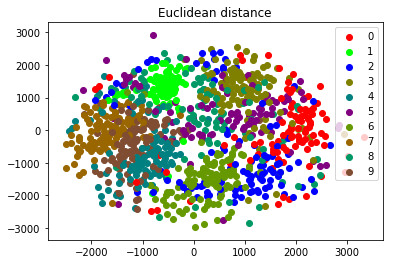

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
def visualize_pcoa_2d(pos,title):
    fig, ax = plt.subplots()
    colors=((1,0,0),(0,1,0),(0,0,1),(0.5,0.5,0),(0,0.5,0.5),(0.5,0,0.5),(0.4,0.6,0),(0.6,0.4,0),(0,0.6,0.4),(0.5,0.3,0.2),)
    for i in range(pos.shape[0]):
        ax.scatter(pos[i,0],pos[i,1],label = train_label[i],color=colors[train_label[i]])

    #remove duplicate in legend
    handles,labels=ax.get_legend_handles_labels()
    handles_unique, labels_unique = [],[]
    seen = set()
    for i,e in enumerate(labels):
        if e not in seen:
            seen.add(e)
            handles_unique.append(handles[i])
            labels_unique.append(e)
            if len(seen) == 10:
                break

    #sort legend
    labels_unique, handles_unique = (list(l) for l in zip(*sorted(zip(labels_unique, handles_unique))))

    plt.legend(handles_unique,labels_unique,loc="best")
    plt.title(title)
    plt.show()

    

#Example: visualization of euclidean distance
visualize_pcoa_2d(pos_euclidean, "Euclidean distance")
